In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
from scipy.stats import chi2_contingency
from matplotlib.ticker import FuncFormatter

import seaborn as sns
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set_context('notebook')
sns.set_style("ticks")
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

df = pd.read_excel("car_evaluation.xlsx", names=['price', 'maintenance', 'no_of_doors',  'seat', 'boot_space','safety','class'], header=None)
df

,price,maintenance,no_of_doors,seat,boot_space,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


In [2]:
df[df['safety']==2]['class'].value_counts()

Series([], Name: class, dtype: int64)

In [3]:
df.replace({'class': {"unacc": 1, "acc": 2, "good": 3, "vgood": 4}}, inplace=True)
df.replace({'price': {"low": 1, "med": 2, "high": 3, "vhigh": 4}}, inplace=True)
df.replace({'no_of_doors': {"5more": 5}}, inplace=True)
df.replace({'seat': {"more": 5}}, inplace=True)
df.replace({'maintenance': {"low": 1, "med": 2, "high": 3, "vhigh": 4}}, inplace=True)
df.replace({'boot_space': {"small": 1, "med": 2, "big": 3}}, inplace=True)
df.replace({'safety': {"low": 1, "med": 2, "high": 3}}, inplace=True)


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, precision_score, confusion_matrix, accuracy_score, plot_confusion_matrix, classification_report, f1_score

X = df.drop(['class'], axis = 1)
y = df['class']

X_train_unencoded, X_test_unencoded, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y)
print("X_train: {}".format(X_train_unencoded.shape))
print("X_test: {}".format(X_test_unencoded.shape))
print("Y_train: {}".format(y_train.shape))
print("Y_test: {}".format(y_test.shape))


X_train: (1382, 6)
X_test: (346, 6)
Y_train: (1382,)
Y_test: (346,)


In [5]:
y_test.value_counts()

1    242
2     77
3     14
4     13
Name: class, dtype: int64

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

clf = RandomForestClassifier(n_estimators= 20, criterion="gini", max_depth= 6, random_state = 42)
clf.fit(X_train_unencoded, y_train)

yp_test = clf.predict(X_test_unencoded)
confusion_matrix(yp_test,y_test.values) 

array([[232,   0,   0,   0],
       [ 10,  76,   9,   5],
       [  0,   1,   4,   0],
       [  0,   0,   1,   8]], dtype=int64)

In [17]:
print(classification_report(y_test, yp_test))

              precision    recall  f1-score   support

           1       1.00      0.97      0.98       242
           2       0.87      0.88      0.88        77
           3       0.67      0.86      0.75        14
           4       0.71      0.77      0.74        13

    accuracy                           0.94       346
   macro avg       0.81      0.87      0.84       346
weighted avg       0.94      0.94      0.94       346



### Decision Tree Classifier

In [8]:
dt = DecisionTreeClassifier(random_state = 42,  criterion="gini", max_depth = 6) # Keeping max_depth=7 to avoid overfitting
dt.fit(X_train_unencoded, y_train)

yp_test = dt.predict(X_test_unencoded)
confusion_matrix(yp_test,y_test.values) 

array([[235,   1,   0,   0],
       [  7,  68,   0,   3],
       [  0,   6,  12,   0],
       [  0,   2,   2,  10]], dtype=int64)

In [9]:
print(classification_report(y_test, yp_test))

              precision    recall  f1-score   support

           1       1.00      0.97      0.98       242
           2       0.87      0.88      0.88        77
           3       0.67      0.86      0.75        14
           4       0.71      0.77      0.74        13

    accuracy                           0.94       346
   macro avg       0.81      0.87      0.84       346
weighted avg       0.94      0.94      0.94       346



### Grid Search of Random Forest Classifier

In [10]:
grid_params = {
    'max_depth': (3,4,5,6,7),
    "criterion": ["gini"], #, "entropy"],
    'class_weight' : ["balanced", "None"],
    'min_samples_split': (2, 4),
    'min_samples_leaf' : (1, 2)
}

In [11]:
grid_clf = GridSearchCV(RandomForestClassifier(),grid_params, cv=4, n_jobs=-1, verbose=1, scoring = "f1_macro")
grid_clf.fit(X_train_unencoded,y_train)

Fitting 4 folds for each of 40 candidates, totalling 160 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced', 'None'],
                         'criterion': ['gini'], 'max_depth': (3, 4, 5, 6, 7),
                         'min_samples_leaf': (1, 2),
                         'min_samples_split': (2, 4)},
             scoring='f1_macro', verbose=1)

In [12]:
best_model = grid_clf.best_estimator_
best_model

RandomForestClassifier(class_weight='balanced', max_depth=7, min_samples_leaf=2,
                       min_samples_split=4)

In [13]:
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]   #gives the index of highest importances in descending order
# columns= df.columns + list(column_names)
# names=[columns[i] for i in indices]

In [14]:
names=[df.columns[i] for i in indices]
names

['safety', 'price', 'maintenance', 'seat', 'boot_space', 'no_of_doors']

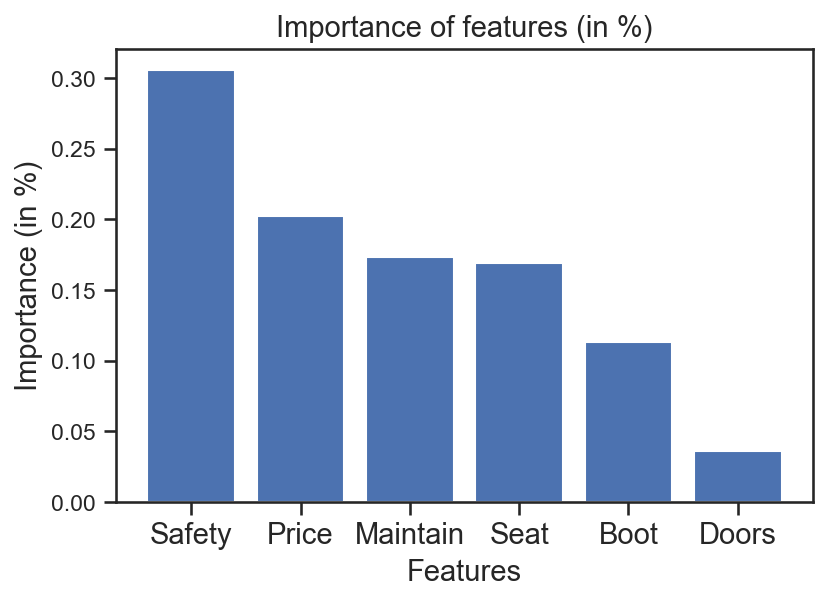

In [15]:
plt.bar(range(X_train_unencoded.shape[1]),importances[indices])
plt.xticks(range(X_train_unencoded.shape[1]),['Safety','Price','Maintain','Seat','Boot','Doors'],rotation=0, size = 14)
plt.xlabel('Features', size = 14)
plt.ylabel('Importance (in %)', size = 14)
plt.title('Importance of features (in %)', size = 14)
plt.show()

In [16]:
print(grid_clf.best_score_,grid_clf.best_params_)

0.8938584269124699 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 4}
